# Simulación LegPy de una fuente de braquiterapia
-----
En este cuaderno se realiza una simulación Montecarlo mediante LegPy de una semilla empleada en implantes permanentes para el tratamiento del cáncer de próstata.

Los resultados se comparan con cálculos analíticos realizados según el formalismo del TG43 de la AAPM.

## Montar gDrive

Para acceder a los archivos almacenados en nuestro Google Drive desde cuadernos Colab primero es necesario montar el disco.

El siguiente código realiza ese proceso. Para completarlo Colab nos pedira autorización para acceder a nuestro disco

In [22]:
# - Importar el módulo para acceder a Drive
from google.colab import drive
# - Montar el disco
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Cambiamos al directorio de trabajo

In [24]:
%cd '/content/gdrive/MyDrive/Física Radioterapia Master Física Biomédica/ProblemaFuenteBraquiterapia'

/content/gdrive/MyDrive/Física Radioterapia Master Física Biomédica/ProblemaFuenteBraquiterapia


Instalamos subversion y descargamos el código del módulo LegPy

In [23]:
!apt install subversion
!svn checkout https://github.com/csarux/TutorialesFisicaRadioterapia/trunk/Enunciados/FuenteBraquiterapia/LegPy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.13.0-3ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


Importamos los módulos y funciones que utilizaremos en este cuaderno

In [26]:
import LegPy as lpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d as cspline, interp2d

### Definir el medio y la geometría

In [14]:
# tamaño del medio (cilindro)
length = 14. # cm
width = 14. # cm diametro
nz, nr = 112, 56 # intervalos en z y r
medium = lpy.Medium(name='Water') # otros medios: 'Bone', 'Tissue', 'Muscle'
geometry = lpy.Geometry(name='cylinder', z = length, r = width/2., n_z = nz, n_r = nr) # Cylindrical voxelization

### Espectro de energía de la fuente

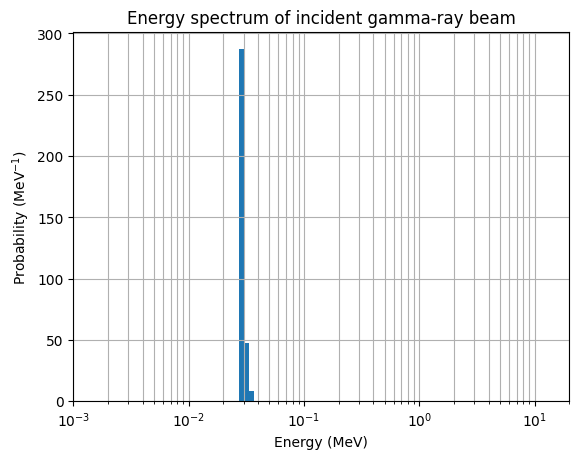

In [15]:
E = np.array([[0.02720, .406], [0.02747, .757], [0.03098, .202], [0.03171, .0439], [0.03549, .0668]] ) #125I 

spectrum = lpy.Spectrum(name = 'multi_mono', E_w = E)
spectrum.plot(n_part = 100, n_bin = 100)

### Geometría de la fuente

In [16]:
x, y, z = 0., 0., 7. # cm posición del centro de la fuente
s_length = 0.45 # cm longitud de la semilla
s_width = 0.05 # cm radio de la semilla
beam = lpy.Beam(name = 'isotropic', length = s_length, r_width = s_width, p_in = np.array ([x, y, z]))

### Visualizar algunas trazas

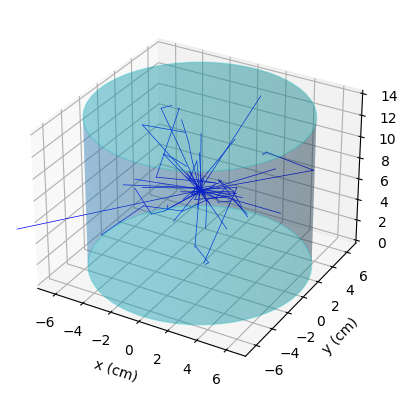

In [17]:
lpy.Plot_beam(medium, geometry, spectrum, beam)

### Realizar la simulación

In [48]:
n_ph = int(1.e7) # números de fotones a simular
output = lpy.MC(medium, geometry, spectrum, beam, n_part = n_ph, E_cut = 0.001)


The simulation has ended

Computing time per beam particle =  2.19e-04 seconds



### Resultado de la simulación 

In [ ]:
# Usamos el dataFrame generado en la simulación
Ddf = output.Edep_to_df()

Obtenemos las coordenadas y los valores de deposito de energía.

Seleccionar el deposito de energía en función de la distancia radial en el plano perpedicular a la fuente y que la bisecciona.

In [ ]:
X = np.array(Ddf.columns)
Y = np.array(Ddf.index)
Z = Ddf.to_numpy()
Dr = Z[55]

Obtener el factor de normalización del depósito de dosis. De acuerdo al formalismo de la AAPM se normaliza a un 1 cm de la fuente. Las coordenadas más próximas a 1 son

In [ ]:
X[7], X[8]

(0.9375, 1.0625)

Interpolamos para X = 1 cm

In [ ]:
Drn = Dr[7] + (Dr[8] - Dr[7])/(X[8] - X[7])*(1.-X[7])

## Comparación y validación de los resultados

Comparamos el deposito de dosis calculado con el derivado del formalismo de TG43 AAPM

https://aapm.onlinelibrary.wiley.com/doi/epdf/10.1118/1.1646040

#### Formalismo

Aproximación 2D
\begin{equation}
    \dot D(r) = S_K \Lambda \frac{G_L(r, \theta)}{G_L(r_0, \theta_0)}g_L(r)F(r, \theta)
\end{equation}

Aproximación 1D, distribución isótropa, fuente puntual
\begin{equation}
    \dot D(r) = S_K \Lambda \frac{G_L(r, \theta_0)}{G_L(r_0, \theta_0)}g_L(r)\phi_{an}(r)
\end{equation}

donde en ambas aproximaciones 
\begin{equation}
G_L(r, \theta)= \left\{ \begin{array}{lcc}
                             \frac{\beta}{Lr\sin(\theta)} & si & \theta \neq 0 \\
                             \frac{1}{r^2-L^2/4} & si & \theta = 0 
                         \end{array}
               \right.
\end{equation}

Para la fuente considerada su longitud efectiva es $L$ = 0.35 cm

Para poder calcular la distribución de tasa de dosis tenemos que calcular $\beta$ en función de $r$ y $\theta$, $\beta = \beta(r, \theta)$.

Por construcción de triángulos es inmediato ver que $\beta = \theta_2 - \theta_1$ y que se verifican las ecuaciones

\begin{equation}
    \theta_1 = \arctan\left( \frac{r \sin (\theta)}{r \cos (\theta) + L/2} \right)
\end{equation}

\begin{equation}
\theta_2 = \left\{ \begin{array}{lcc}
                       \arctan \left(\frac{r \sin(\theta)}{r \cos(\theta)-L/2}\right) & si & r \cos(\theta) > L/2 \\
                       \pi/2 & si & r \cos(\theta) = L/2 \\
                       \pi/2 + \arctan \left(\frac{L/2 + r \cos(\theta)}{r \sin(\theta)}\right) & si & r \cos(\theta) < L/2 
                   \end{array}
           \right.
\end{equation}

De donde obtendríamos $\beta = \beta(r, \theta)$

#### Validación

Calculamos la función $g_L(r)$ a partir del depósito relativo de energía 
\begin{equation}
  g_L(r) = \frac{\dot D(r)}{\dot D(r_0)}\frac{G_L(r_0, \theta_0)}{G_L(r, \theta_0)}
\end{equation}

Donde hemos tenido en cuenta que en la aproximación 2D $F(r, \theta_0) = 1$ 

### Cálculos TG43 para la fuente Bebig de I125

Unidades: longitudes en cm y ángulos en grados sexagesimales

Constante con la longitud efectiva de la fuente

In [32]:
L = 0.35

Constantes con las coordendas del punto de referencia

In [33]:
r0, theta0 = 1, 90

Constante para el cambio de grados sexagesimales a radianes

In [34]:
d_r = np.pi/180

Definimos la función $\beta(r, \theta)$

In [35]:
def beta(r, theta):
    if r * np.cos(theta) > L/2:
        return np.arctan(r*np.sin(theta)/(r*np.cos(theta)-L/2)) - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2))
    elif r * np.cos(theta) == L/2:
        return np.pi/2 - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2))
    else:
        return (np.pi/2 + np.arctan((L/2-r*np.cos(theta))/r/np.sin(theta)) 
                - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2)))

Definimos la función $G_L(r, \theta)$

In [36]:
def G_L(r, theta):
    if theta == 0:
        return 1 / (r**2 - L**2/4)
    else:
        return beta(r, theta)/(L * r * np.sin(theta))

Definimos la constante de normalización de la función de geometría $G_L(r_0, \theta_0)$

In [37]:
G_L_r0_theta0 = G_L(r0, theta0 * d_r)

Vectorizamos la función para facilitar los cálculos posteriores

In [38]:
G_L_v = np.vectorize(G_L)

Leemos los datos tabulados de la AAPM

Función de dosis radial $g_L$, función de anisotropía $\phi_{an}(r)$ para la aproximación 1D y función $F(r, \theta)$ para el tratamiento 2D

In [39]:
# Descargar los datos tabulados de la fuente
!wget https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/FuncionesDosimetricas.xlsx

--2023-04-25 14:50:10--  https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/FuncionesDosimetricas.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7978 (7.8K) [application/octet-stream]
Saving to: ‘FuncionesDosimetricas.xlsx’

FuncionesDosimetric 100%[===================>]   7.79K  --.-KB/s    in 0.001s  

2023-04-25 14:50:10 (9.82 MB/s) - ‘FuncionesDosimetricas.xlsx’ saved [7978/7978]



In [40]:
# Cargamos las tablas de la AAPM
gdf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='g')
phiandf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='phi_an')
Fdf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='F')

Comparar la función radial calculada con LegPy y la aproximación analítica

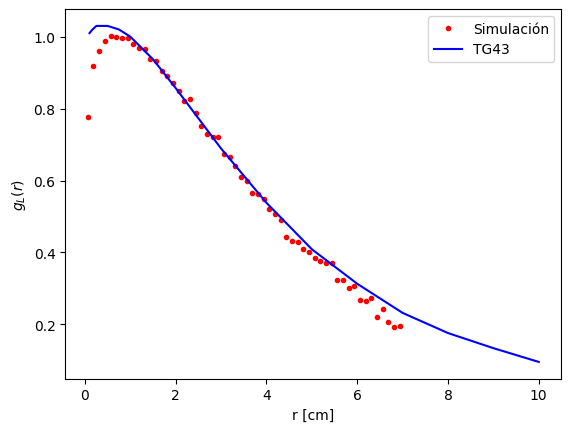

In [55]:
fig, ax = plt.subplots()
ax.plot(X, Dr/Drn * G_L_r0_theta0/G_L_v(X, 90*d_r), 'r.')
ax.plot(gdf.r, gdf.Lineal, 'b-')

ax.set_xlabel('r [cm]')
ax.set_ylabel('$g_L(r)$')

ax.legend(['Simulación', 'TG43'])
plt.show()

## Implementación continua de las tablas de la AAPM
El código definido en esta sección implementa funciones que leen los datos de las tablas de la AAPM y mediante interpolación permiten generar datos continuos en el espacio.

Todas estas funciones se vectorizan. Recordemos que a una función que soporta vectorización se le puede pasar un array y la función se aplicará sobre cada elemento del array sin necesidad de iterar. Por tanto una función vectorizada devuelve un array de las mismas dimensiones que el array de entrada.

In [65]:
### - Este código no se tiene que modificar - ###
# Definit la función g_L
def g_L(r):
    return gdf.loc[gdf['r']==r]['Lineal'].values[0]
# Vectorizarla
g_L_v = np.vectorize(g_L)

# Definir la función de anisotropia 1D
def phi_an(r):
    return phiandf.loc[phiandf['r']==r]['phi'].values[0]
# Vectorizarla
phi_an_v = np.vectorize(phi_an)

# Definir la función de anisotropia 2D
def F(r, theta):
    theta = abs(theta)
    return Fdf.loc[Fdf['theta']==theta][r].values[0]
# Vectorizarla
F_v = np.vectorize(F)

Para generar el gráfico con la distribución espacial de la tasa de dosis en una geometría similar a la de la simulación definimos los vectores con el muestreo de $r$ y $\theta$

In [66]:
### - Este código no se tiene que modificar - ###
rv = np.array([0.25, 0.5, 1., 2., 3.,  4., 5., 7.])
thetav = Fdf['theta'].values

# La AAPM aprovecha la geometría del problema y solo tabula un cuadrante. 
# En LegPy ha sido más sencillo calcular dos cuadrantes.
# Extendemos thetav con los valores negativos para hacer coincidir ambas geometrías
minusthetav = -thetav
thetas = thetav.tolist() + minusthetav[1:].tolist()
thetas.sort()
thetav = np.array(thetas)

Generamos los mallados de coordenadas

In [67]:
### - Este código no se tiene que modificar - ###
R, Theta = np.meshgrid(rv, thetav * d_r) # Ángulos en radianes
R, ThetaDeg = np.meshgrid(rv, thetav)    # Ángulos en grados sexagesimales

Definimos las funciones de interpolación para las funciones $g_L$, $F$ y  $\phi_{an}$ y las vectorizamos

In [68]:
### - Este código no se tiene que modificar - ###
%%capture --no-display

# Definir funciones
g_Lf = cspline(rv, g_L_v(rv), kind='cubic', bounds_error=False, fill_value="extrapolate")
Ff = interp2d(R, ThetaDeg, F_v(R, ThetaDeg), kind='cubic', bounds_error=False, fill_value=None)
phi_anf = cspline(rv, phi_an_v(rv), kind='cubic', bounds_error=False, fill_value="extrapolate")

# Vectorizarlas
Ffv = np.vectorize(Ff)
phi_anfv = np.vectorize(phi_anf)

### Comparación con las aproximaciones 1D y 2D del TG43

#### Curvas de isovalores, igual tasa de dosis

Comparamos la distribución calculada utilizando LegPy con la aproximación 1D de la AAPM.

Calculamos primero un valor de renormalización igualando el valor de ambas distribuciones en el punto de referencia

In [69]:
def norm_val(S, Phi, Dr):
    Drn = Dr[7] + (Dr[8] - Dr[7])/(X[8] - X[7])*(1.-X[7])
    return G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * phi_anfv(S)/Drn

knorm = norm_val(1, 0, Dr)

Comparación con la aproximación 1D

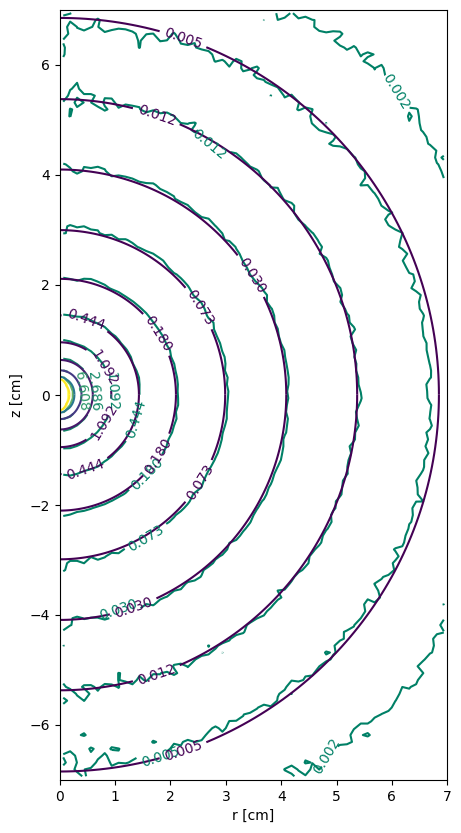

In [76]:
%%capture --no-display
# Aproximación 1D
# Vectores con las coordenadas radial 's' y angular 'phi'
sv, phiv = np.arange(0, 7.05, 0.1), np.arange(0.0, 90.05, 1)
# Establecer el mallado de coordenandas necesario para la representación 2D
# Coordenadas polares
S, Phi = np.meshgrid(sv, phiv)
# Coordenadas cartesianas
U, V = S * np.sin(Phi*d_r), S * np.cos(Phi*d_r)
# Cálculo de la aproximación 1D
D_rate_den_1D = G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * phi_anfv(S)
# Construir la figura
fig, ax = plt.subplots(figsize=(5, 10))
# Definir los niveles de las isodosis
levels = np.geomspace(0.002, 40., 12)
# Representar la simulación realizada por LegPy, recentrándola para colocar la fuente en el origen
CSL = ax.contour(X, Y - 7, knorm * Z, levels=levels, cmap='summer')
ax.clabel(CSL, levels, fmt='%4.3f')
# Representar la aproximación 1D
CS1D = ax.contour(U, V, D_rate_den_1D, levels=levels, cmap='viridis')
ax.clabel(CS1D, levels, fmt='%4.3f')
CS1D = ax.contour(U, -V, D_rate_den_1D, levels=levels, cmap='viridis')
ax.clabel(CS1D, levels, fmt='%4.3f')
# Formato de los ejes
ax.set_xlabel('r [cm]')
ax.set_ylabel('z [cm]')
plt.show()

Comparación con la aproximación 2D

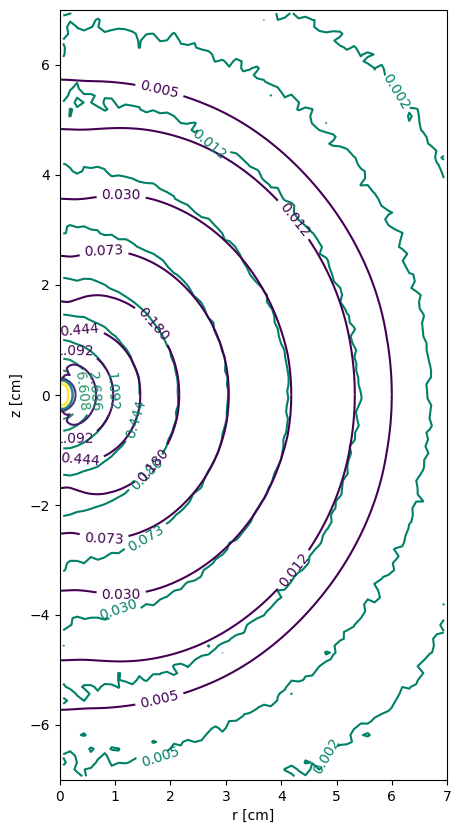

In [75]:
%%capture --no-display
# Aproximación 2D
# Vectores con las coordenadas radial 's' y angular 'phi'
sv, phiv = np.arange(0, 7.05, 0.1), np.arange(-0.0, 90.05, 1)
# Establecer el mallado de coordenandas necesario para la representación 2D
# Coordenadas polares
S, Phi = np.meshgrid(sv, phiv)
# Coordenadas cartesianas
U, V = S * np.sin(Phi*d_r), S * np.cos(Phi*d_r)
# Cálculo de la aproximación 2D
D_rate_den_2D = G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * Ffv(S, Phi)
# Construir la figura
fig, ax = plt.subplots(figsize=(5, 10))
# Definir los niveles de las isodosis
levels = np.geomspace(0.002, 40., 12)
# Representar la simulación realizada por LegPy
CSL = ax.contour(X, Y - 7, Z * knorm, levels=levels, cmap='summer')
ax.clabel(CSL, levels, fmt='%4.3f')
# Representar la aproximación 2D
CS2D = ax.contour(U, V, D_rate_den_2D, levels=levels)
ax.clabel(CS2D, levels, fmt='%4.3f')
CS2D = ax.contour(U, -V, D_rate_den_2D, levels=levels)
ax.clabel(CS2D, levels, fmt='%4.3f')
# Formato de los ejes
ax.set_xlabel('r [cm]')
ax.set_ylabel('z [cm]')
plt.show()